<a href="https://colab.research.google.com/github/Supersamk13/Machine-Learning-and-Data-Science/blob/main/Data_Science_and_Machine_Learning_Project_Interstate_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Hello, my name is Samuel Kinstlinger. Over the past couple years I have been working on growing my skillset is the fields of data science and machine learing. This is a project I completed early on in my endeavor to practice data cleaning, data preprocessing, data visualization, and implementing regression models. I will be using a data set from Kaggle that gives information on the weather, date and time, and traffic volume. For each choice I made working on this project, I did many hours of research, implemented/tested multiple solutions, and chose the best option. I only left in the final decisions for the purpose of concision. I also did testing after each logical section, but deleting the basic testing for the final version.

### Goals
* Answer important questions about interstate traffic and the underlying related factors
* Implement and tune machine learning models to best predict interstate traffic volume

### Outline
* Getting to Know the Data
* Treatment/Analysis of Outliers and Missing Data
* Feature Engineering (Noise, Outlier, and Structural Error Analysis/Treatment)
* Answering EDA Questions
* Feature Engineering (Data Cleaning and Transformations)
* Feature Engineering (Imbalanced Data Analysis/Treatment)
* Feature Engineering (Optimizing for Training)
* Dimensionality Reduction Analysis/Treatment + Machine Learning
* Conclusion

In [369]:
# Import modules/libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
%matplotlib inline

In [370]:
# Set up data frame
url='https://github.com/Supersamk13/Machine-Learning-and-Data-Science/raw/main/Metro_Interstate_Traffic_Volume%5B1%5D.csv'
traffic_df=pd.read_csv(url)

# Getting to Know the Data
* Understanding feature data types and information

In [371]:
# Getting to Know the Data
print(traffic_df.head())
print(traffic_df.tail())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  
      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0   

In [372]:
print(traffic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
None


* All data is non-null; no need to fill or remove missing values
* If there were missing data, I would either remove it if it was negligible or do some KNN imputation to fill it in otherwise (or a superior model)

In [373]:
for index in range(traffic_df.shape[1]):
  print(traffic_df.columns[index])
  print(traffic_df.iloc[:,index].unique())

holiday
['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
temp
[288.28 289.36 289.58 ... 306.08 304.41 304.9 ]
rain_1h
[0.0000e+00 2.5000e-01 5.7000e-01 3.8000e-01 3.0000e-01 2.9000e-01
 4.4000e-01 3.6000e-01 2.1600e+00 3.3900e+00 8.4000e-01 7.6000e-01
 5.1000e-01 6.9000e-01 1.0000e+00 1.2900e+00 1.3400e+00 1.8400e+00
 1.7000e+00 4.7000e-01 1.4100e+00 1.4400e+00 7.0000e-01 3.1800e+00
 6.1000e-01 6.4000e-01 1.0200e+00 5.4200e+00 8.6400e+00 5.7400e+00
 4.9800e+00 3.6500e+00 6.8000e-01 4.6000e-01 4.2000e-01 1.5200e+00
 8.9000e-01 1.4000e+00 1.2190e+01 2.2900e+00 7.5400e+00 6.9400e+00
 1.6380e+01 1.7800e+00 2.5400e+00 9.1400e+00 3.0500e+00 1.6500e+00
 4.4450e+01 3.8100e+00 5.8400e+00 3.5600e+00 7.3700e+00 1.3500e+00
 1.6000e+01 1.0540e+01 1.2700e+00 5.0800e+00 1.9900e+01 2.5320e+01
 2.1420e+01 5.5900e+00 7.1100e+00 5.9700e+00 9.5300e+00 2.0

In [374]:
# Stats about each numeric feature
print(traffic_df.describe())

               temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000


In [375]:
# Stats about each categorical feature
print(traffic_df.describe(include='object'))

       holiday weather_main weather_description            date_time
count    48204        48204               48204                48204
unique      12           11                  38                40575
top       None       Clouds        sky is clear  2013-05-19 10:00:00
freq     48143        15164               11665                    6


* holiday is very imbalanced towards no holiday
* holiday and weather_main have a small amount of categories making One-Hot Encoding a viable option for some models (maybe also weather_description)
* For date_time, second is most likely unimportant; note to compare model performance including second vs. excluding second
* Above comment may also be applicable for minute
* date_time may be tricky for parametric models as it requires nuance for analysis


### Feature Conclusions
* holiday- Categorical, US National holidays plus regional holidays
* temp- Numeric, Average temp in kelvin
* rain_1h- Numeric, Amount in mm of rain that occurred in the hour
* snow_1h- Numeric, Amount in mm of snow that occurred in the hour
* clouds_all- Numeric, Percentage of cloud cover
* weather_main- Categorical, Short textual description of the current weather
* weather_description- Categorical, Longer textual description of the current weather
* date_time- DateTime, Hour of the data collected in local CST time
* traffic_volume- Numeric Hourly I-94 ATR 301 reported westbound traffic volume



### Other Data Info
* Shape = (48204, 9)
* Traffic is westbound
* Traffic is between Saint Paul and Minneapolis
* Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume. Collected from 2012-2018.

# Noise Data and Structural Error Analysis/Treatment

In [376]:
traffic_df['weather_description']=traffic_df['weather_description'].apply(lambda x: x.lower())

# Treatment/Analysis of Outliers and Missing Data
* Eliminate outliers (use boxplot and pandas statistical describe function as metrics)
* I am making each data visualization plot to help me in data preprocessing and feature engineering.
* I would make them significantly more user-friendly and communication-oriented if they were meant to be presented or shown to those who are not very familiar with the data.

## Remove Outliers

* Outliers appear to be heavily skewing the feature data
* Due to there being a small amount of outliers and large amount of data, removing the outliers is a viable choice

### traffic_volume

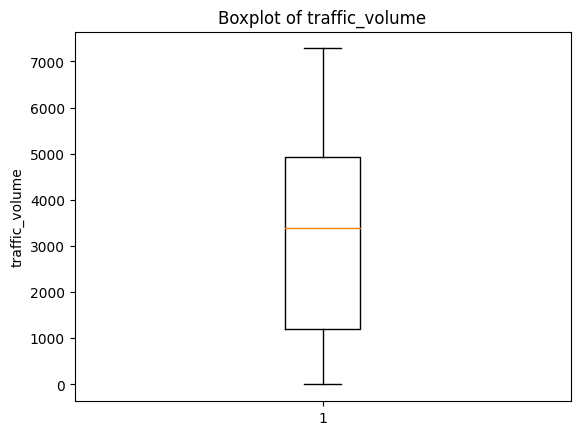

In [377]:
# Boxplot
plt.boxplot(traffic_df['traffic_volume'])

# Add labels
plt.title('Boxplot of traffic_volume')
plt.ylabel('traffic_volume')

plt.show()

In [378]:
# Stats about each numeric feature
print(traffic_df['traffic_volume'].describe())

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64


No apparent outliers

### temp

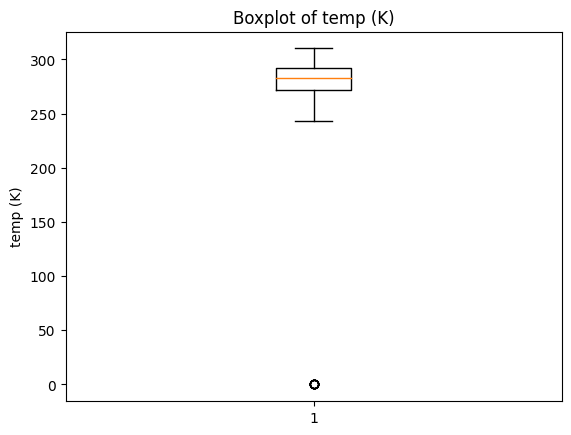

In [379]:
# Boxplot
plt.boxplot(traffic_df['temp'])

# Add labels
plt.title('Boxplot of temp (K)')
plt.ylabel('temp (K)')

plt.show()

In [380]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    48204.000000
mean       281.205870
std         13.338232
min          0.000000
25%        272.160000
50%        282.450000
75%        291.806000
max        310.070000
Name: temp, dtype: float64


Remove outlier at 0 (most likely false entry/mistake)

In [381]:
# Remove outliers
traffic_df=traffic_df[np.absolute(stats.zscore(traffic_df['temp']))<3]

Recheck data

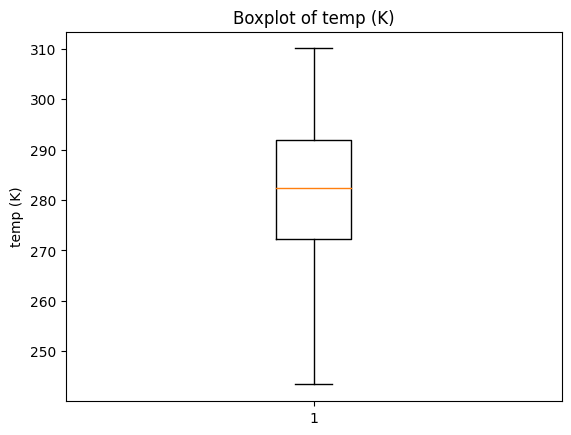

In [382]:
# Boxplot
plt.boxplot(traffic_df['temp'])

# Add labels
plt.title('Boxplot of temp (K)')
plt.ylabel('temp (K)')

plt.show()

In [383]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    48194.000000
mean       281.264219
std         12.709587
min        243.390000
25%        272.182500
50%        282.460000
75%        291.810000
max        310.070000
Name: temp, dtype: float64


No apparent outliers

### clouds_all

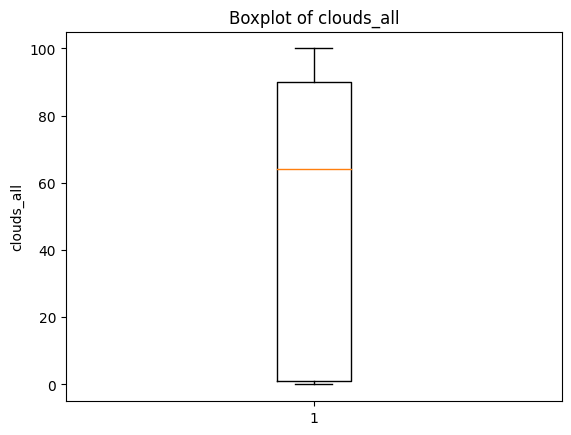

In [384]:
# Boxplot
plt.boxplot(traffic_df['clouds_all'])

# Add labels
plt.title('Boxplot of clouds_all')
plt.ylabel('clouds_all')

plt.show()

In [385]:
# Stats about each numeric feature
print(traffic_df['clouds_all'].describe())

count    48194.000000
mean        49.372474
std         39.013317
min          0.000000
25%          1.000000
50%         64.000000
75%         90.000000
max        100.000000
Name: clouds_all, dtype: float64


No apparent outliers

### rain_1h

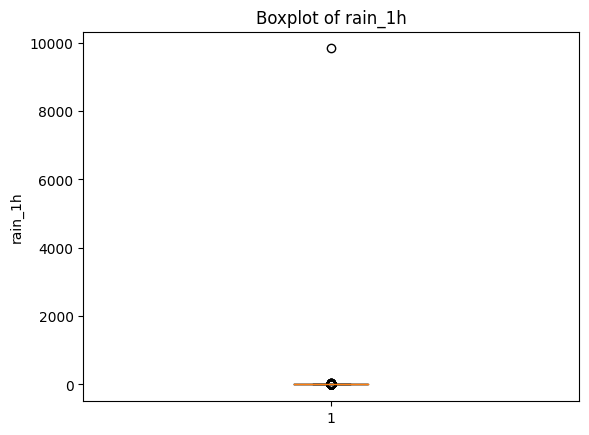

In [386]:
# Boxplot
plt.boxplot(traffic_df['rain_1h'])

# Add labels
plt.title('Boxplot of rain_1h')
plt.ylabel('rain_1h')

plt.show()

In [387]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48194.000000
mean         0.334333
std         44.793779
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9831.300000
Name: rain_1h, dtype: float64


Some apparent outlier

In [388]:
# Remove outliers
traffic_df=traffic_df[np.absolute(stats.zscore(traffic_df['rain_1h']))<.9]

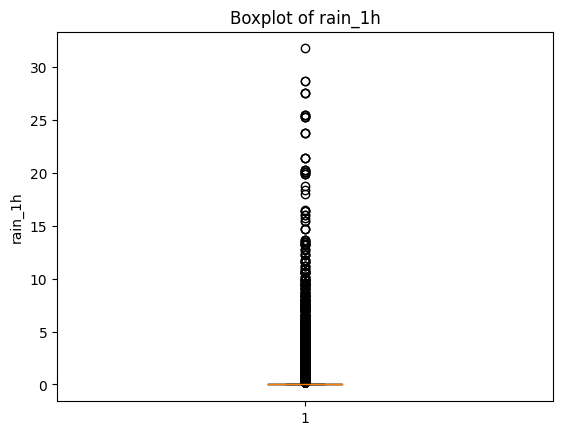

In [389]:
# Boxplot
plt.boxplot(traffic_df['rain_1h'])

# Add labels
plt.title('Boxplot of rain_1h')
plt.ylabel('rain_1h')

plt.show()

In [390]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48191.000000
mean         0.128270
std          0.949912
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         31.750000
Name: rain_1h, dtype: float64


Data has no apparent harmful or misleading outliers; deal with zero-inflation later

### snow_1h

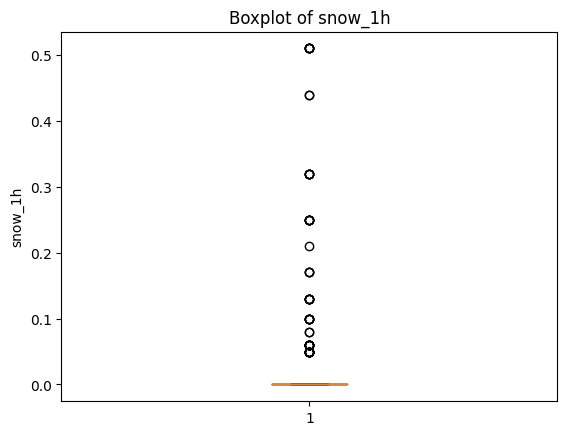

In [391]:
# Boxplot
plt.boxplot(traffic_df['snow_1h'])

# Add labels
plt.title('Boxplot of snow_1h')
plt.ylabel('snow_1h')

plt.show()

In [392]:
# Stats about each numeric feature
print(traffic_df['snow_1h'].describe())

count    48191.000000
mean         0.000222
std          0.008169
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.510000
Name: snow_1h, dtype: float64


Data has no apparent harmful or misleading outliers; deal with zero-inflation later

* Eliminate skew in numerical features and target (use histogram, pandas statistical describe function, and pandas skew function as metrics)
* Finally normalize each numerical feature

# Feature Engineering

#### To Investigate Possible Patters

### Weather
* Currently there are two weather columns: simple description (weather_main) and complex description (weather_description). The simple description is essentially an umbrella term for certain complex descriptions. I will feature engineer the weather to one column, then use binary encoding to turn the data into numerical.

In [393]:
print(traffic_df['weather_main'].unique())

['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']


In [394]:
print(traffic_df['weather_description'].unique())

['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'squalls'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'very heavy rain' 'thunderstorm with light drizzle'
 'light snow' 'thunderstorm with drizzle' 'smoke' 'shower drizzle'
 'light shower snow' 'sleet']


Due to weather_description containing weather_main with more information, I have decided to remove weather_main

In [395]:
# To delete weather_main
traffic_df=traffic_df.drop('weather_main', axis=1)

I will now attempt to reduce the cardinality of weather_description

I will combine weather_descriptions into groups based on similarity in other dataset features

I will group the data based on their weather_description categories.

Then I will use the pandas aggregate function to see mean values of other numerical features in the dataset for each category in weather_description

In [396]:
print(traffic_df.groupby('weather_description').aggregate({'temp':[np.mean,np.size],'rain_1h':np.mean, 'snow_1h':np.mean, 'clouds_all':np.mean, 'traffic_volume':np.mean}))

                                           temp           rain_1h   snow_1h  \
                                           mean   size       mean      mean   
weather_description                                                           
broken clouds                        281.188939   4666   0.000000  0.000000   
drizzle                              283.005776    651   0.118710  0.000000   
few clouds                           284.128469   1956   0.000000  0.000000   
fog                                  279.415713    912   0.087007  0.000625   
freezing rain                        272.860000      2   0.000000  0.000000   
haze                                 275.818581   1360   0.046868  0.000000   
heavy intensity drizzle              285.116406     64   0.170156  0.000000   
heavy intensity rain                 290.326981    467   2.656660  0.000000   
heavy snow                           269.155536    616   0.001234  0.000000   
light intensity drizzle              284.246327   11

Percentage of cloud cover, quantity of rain, and quantity of snow have already ben accounted for

I will group those with an important feature being percentage of cloud cover, quantity of rain, and quantity of snow into cloudy, rain, snow, respectively

In [397]:
# Replace weather_description
traffic_df['weather_description']=traffic_df['weather_description'].apply(lambda x: 'rain' if x in ['freezing rain', 'drizzle','heavy intensity drizzle', 'heavy intensity rain', 'light intensity drizzle', 'light intensity shower rain', 'light rain', 'moderate rain', 'proximity shower rain', 'shower drizzle', 'very heavy rain']
                                                                          else 'cloudy' if x.__contains__('cloud')
                                                                          else 'snow' if x.__contains__('snow') or x=='sleet'
                                                                          else 'thunderstorm' if x.__contains__('thunderstorm') or x=='squalls'
                                                                          else 'sky is clear' if x=='smoke'
                                                                          else x)

In [398]:
print(traffic_df.groupby('weather_description').aggregate({'temp':[np.mean,np.size],'rain_1h':np.mean, 'snow_1h':np.mean, 'clouds_all':np.mean, 'traffic_volume':np.mean}))

                           temp          rain_1h   snow_1h clouds_all  \
                           mean   size      mean      mean       mean   
weather_description                                                     
cloudy               281.466101  15164  0.000000  0.000000  64.056120   
fog                  279.415713    912  0.087007  0.000625  51.497807   
haze                 275.818581   1360  0.046868  0.000000  58.670588   
mist                 279.476892   5950  0.238336  0.000728  65.956303   
rain                 286.201958   7490  0.439733  0.000142  74.962750   
sky is clear         281.714107  13401  0.000787  0.000000   1.625177   
snow                 267.955188   2876  0.025223  0.001655  81.465229   
thunderstorm         292.715164   1038  1.198083  0.000000  68.544316   

                    traffic_volume  
                              mean  
weather_description                 
cloudy                 3618.449749  
fog                    2703.720395  
haze       

Binary Encode weather_description

In [399]:
# Create binary number for weather column
traffic_df['weather_description_binary']=traffic_df['weather_description'].apply(lambda x: int(format(0,'b')) if x=='snow' else int(format(1,'b')) if x=='cloudy' else int(format(2,'b')) if x=='sky is clear' else int(format(3,'b')) if x=='rain' else int(format(4,'b')) if x=='mist' else int(format(5,'b')) if x=='haze' else int(format(6,'b')) if x=='fog' else int(format(7,'b')) )

In [400]:
# Convert binary weather_description feature into three binary columns
traffic_df['weather_description_binary_0']=traffic_df['weather_description_binary'].apply(lambda x: int((x/100)%10))
traffic_df['weather_description_binary_1']=traffic_df['weather_description_binary'].apply(lambda x: int((x/10)%10))
traffic_df['weather_description_binary_2']=traffic_df['weather_description_binary'].apply(lambda x: x%10)

In [401]:
# Remove original binary weather_description feature
traffic_df=traffic_df.drop('weather_description_binary', axis=1)

### DateTime
Currently DateTime is set to second, minute, hour, day, month, year

First I'm gonna separate the data into hour, day, month, year, weekday (exclude minute and second because both are the same for all examples/rows)

For weekday, 0-6 is Monday to Sunday

hour, day, month, and year have no distinguishable subsections. However, weekdays and weekends are distinct so I will create an is_weekend feature

Then I will add sin and cos transformation features to hour, day, month, and weekday to capture the circular/cyclical nature of those features

In [402]:
# Convert date_time string to datetime type
traffic_df['date_time']=traffic_df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [403]:
traffic_df['hour']=traffic_df.date_time.dt.hour
traffic_df['day']=traffic_df.date_time.dt.day
traffic_df['month']=traffic_df.date_time.dt.month
traffic_df['year']=traffic_df.date_time.dt.year
traffic_df['weekday']=traffic_df.date_time.dt.weekday

In [404]:
traffic_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,weather_description_binary_0,weather_description_binary_1,weather_description_binary_2,hour,day,month,year,weekday
0,None,288.28,0.0,0.0,40,cloudy,2012-10-02 09:00:00,5545,0,0,1,9,2,10,2012,1
1,None,289.36,0.0,0.0,75,cloudy,2012-10-02 10:00:00,4516,0,0,1,10,2,10,2012,1
2,None,289.58,0.0,0.0,90,cloudy,2012-10-02 11:00:00,4767,0,0,1,11,2,10,2012,1
3,None,290.13,0.0,0.0,90,cloudy,2012-10-02 12:00:00,5026,0,0,1,12,2,10,2012,1
4,None,291.14,0.0,0.0,75,cloudy,2012-10-02 13:00:00,4918,0,0,1,13,2,10,2012,1


In [405]:
# Creating is_weekend
traffic_df['is_weekend']=traffic_df['weekday'].apply(lambda x: 1 if x > 4 else 0)

In [406]:
traffic_df['sin_hour']=np.sin(traffic_df['hour'] * (np.pi/12.0))
traffic_df['cos_hour']=np.cos(traffic_df['hour'] * (np.pi/12.0))
traffic_df['sin_day']=np.sin(traffic_df['day'] * (np.pi/15.5))
traffic_df['cos_day']=np.cos(traffic_df['day'] * (np.pi/15.5))
traffic_df['sin_month']=np.sin(traffic_df['month'] * (np.pi/6.0))
traffic_df['cos_month']=np.cos(traffic_df['month'] * (np.pi/6.0))
traffic_df['sin_weekday']=np.sin(traffic_df['weekday'] * (np.pi/3.5))
traffic_df['cos_weekday']=np.cos(traffic_df['weekday'] * (np.pi/3.5))

I checkes the distributions of each encoded and unencoded feature but only included one of each for brevity

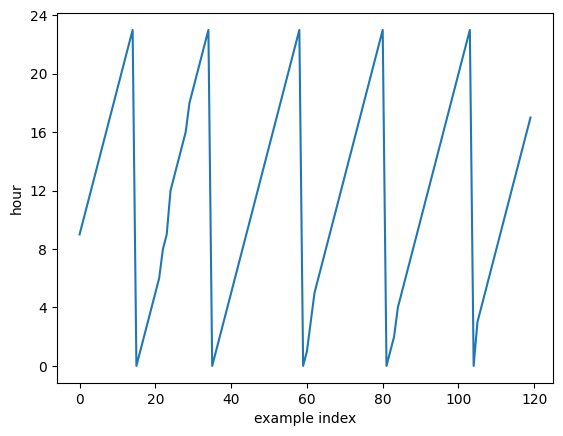

In [407]:
# Raw hour
fig, ax = plt.subplots()
ax=traffic_df['hour'][:120].plot()
# Labels
ax.set_ylabel('hour')
ax.set_xlabel('example index')
# Set Y Tick Marks
ax.set_yticks(np.arange(0,28,4))
plt.show()

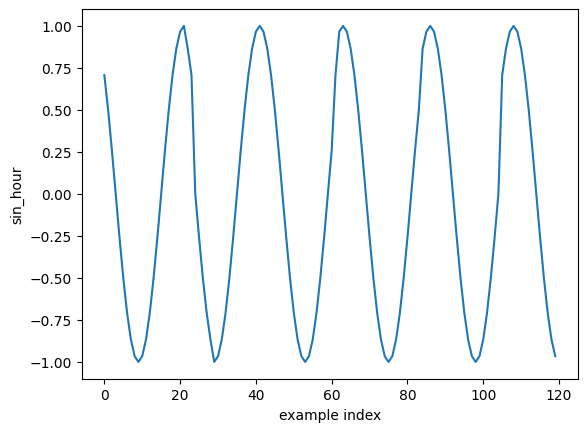

In [408]:
# sin hour
fig, ax = plt.subplots()
ax=traffic_df['sin_hour'][:120].plot()
# Labels
ax.set_ylabel('sin_hour')
ax.set_xlabel('example index')
plt.show()

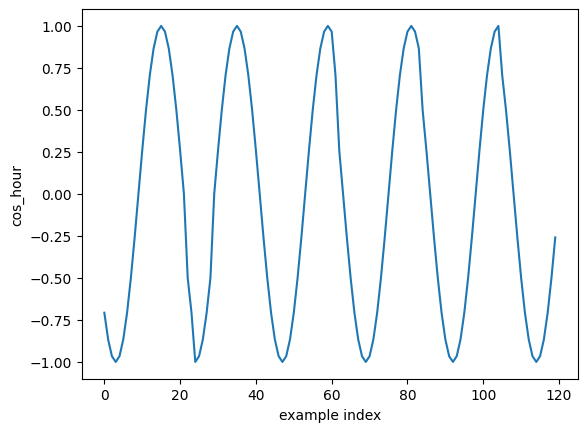

In [409]:
# cos hour
fig, ax = plt.subplots()
ax=traffic_df['cos_hour'][:120].plot()
# Labels
ax.set_ylabel('cos_hour')
ax.set_xlabel('example index')
plt.show()

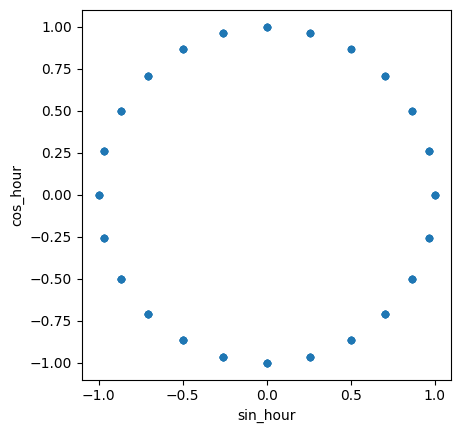

In [410]:
# sin and cos together hour
traffic_df[:120].plot.scatter('sin_hour', 'cos_hour').set_aspect('equal')
plt.show()

In [411]:
# Remove unneeded feature (date_time)
traffic_df=traffic_df.drop('date_time', axis=1)

In [412]:
traffic_df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_description', 'traffic_volume', 'weather_description_binary_0',
       'weather_description_binary_1', 'weather_description_binary_2', 'hour',
       'day', 'month', 'year', 'weekday', 'is_weekend', 'sin_hour', 'cos_hour',
       'sin_day', 'cos_day', 'sin_month', 'cos_month', 'sin_weekday',
       'cos_weekday'],
      dtype='object')

Criteria for Pandas Skew Function

* If the skewness is between -0.2 and 0.2, the data are fairly symmetrical
* If the skewness is between -1 and — 0.2 or between 0.2 and 1, the data are moderately skewed
* If the skewness is less than -1 or greater than 1, the data are highly skewed

# Answering EDA Questions


### What are the best weather indicators of heavy traffic?

Graph a box plot for the traffic_volume each main type of weather

<Axes: xlabel='traffic_volume', ylabel='weather_description'>

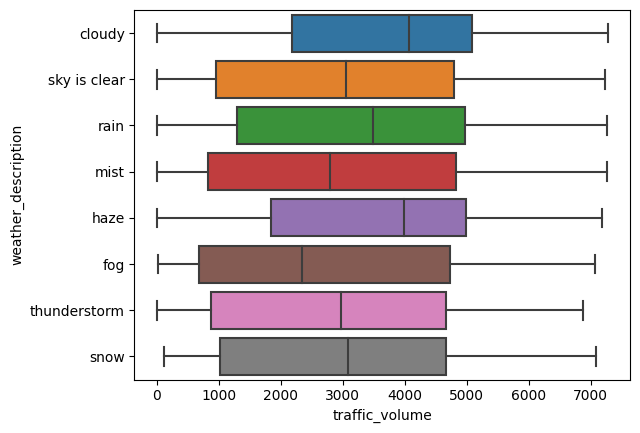

In [413]:
# Create box plots
sns.boxplot(x=traffic_df['traffic_volume'],y=traffic_df['weather_description'])

There appears to be a lot of traffic when it is cloudy or hazy, and very little traffic when it is foggy.

In [414]:
# Remove unneeded feature (weather_description)
traffic_df.drop('weather_description', axis=1, inplace=True)

### During which time of day is traffic the heaviest?

Create new datasets of each portion of the day (Night: 20-3, Morning: 4-11, Afternoon: 12-19)

Plot traffic volume distribution for each

In [415]:
traffic_df_night=traffic_df[(traffic_df['hour']>=20) | (traffic_df['hour']<=3)]
traffic_df_morning=traffic_df[(traffic_df['hour']>=4) & (traffic_df['hour']<=11)]
traffic_df_afternoon=traffic_df[(traffic_df['hour']>=12) & (traffic_df['hour']<=19)]

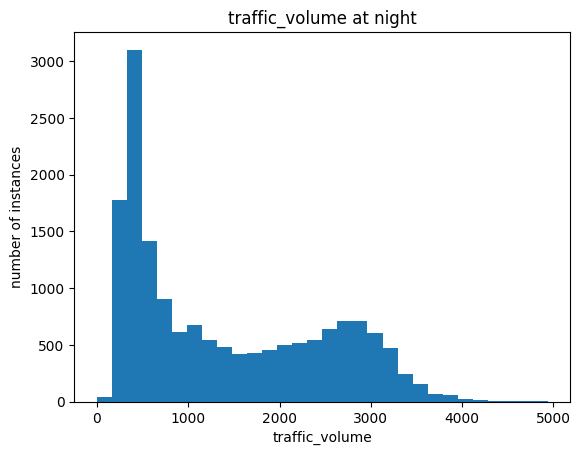

<Figure size 1000x600 with 0 Axes>

In [416]:
# Histogram
plt.hist(traffic_df_night['traffic_volume'], bins=30)

# Labels
plt.xlabel('traffic_volume')
plt.ylabel('number of instances')
plt.title('traffic_volume at night')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

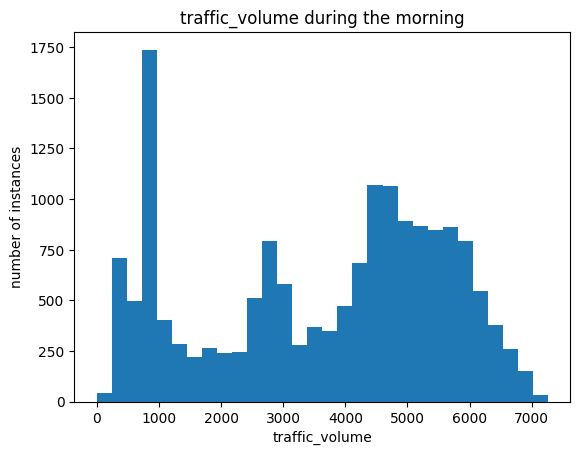

<Figure size 1000x600 with 0 Axes>

In [417]:
# Histogram
plt.hist(traffic_df_morning['traffic_volume'], bins=30)

# Labels
plt.xlabel('traffic_volume')
plt.ylabel('number of instances')
plt.title('traffic_volume during the morning')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

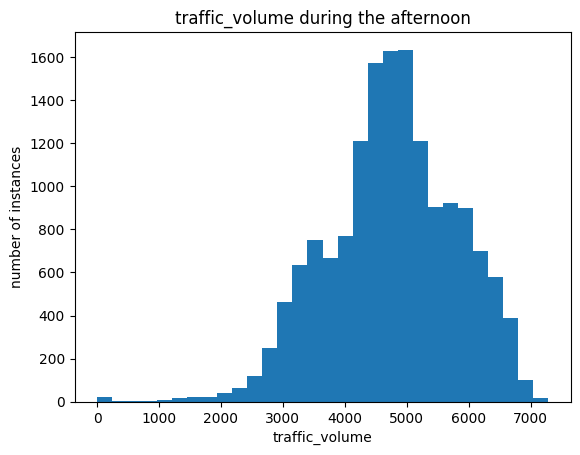

<Figure size 1000x600 with 0 Axes>

In [418]:
# Histogram
plt.hist(traffic_df_afternoon['traffic_volume'], bins=30)

# Labels
plt.xlabel('traffic_volume')
plt.ylabel('number of instances')
plt.title('traffic_volume during the afternoon')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

traffic_volume appears to be greatest in the aftenoon, then the morning, then at night

### Is there more, less, or about the same traffic on holidays?

Create a new feature is_holiday.

Create a bar graph with traffic_volume on the y axis and is_holiday on the x axis

In [419]:
traffic_df['is_holiday']=traffic_df['holiday'].apply(lambda x: 'No' if x=='None' else 'Yes')

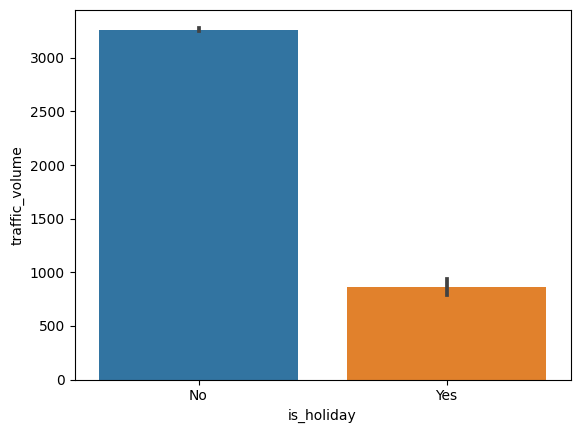

In [420]:
sns.barplot(x=traffic_df['is_holiday'], y=traffic_df['traffic_volume'])
plt.show()

There appears to be more traffic on none-holidays when compared to holidays

### Which holidays lead to the most traffic?

Create a new dataframe with only holidays

Create a boxplot of different holidays

In [421]:
# Create new dataframe
traffic_df_holidays=traffic_df[traffic_df['holiday']!='None']

<Axes: xlabel='traffic_volume', ylabel='holiday'>

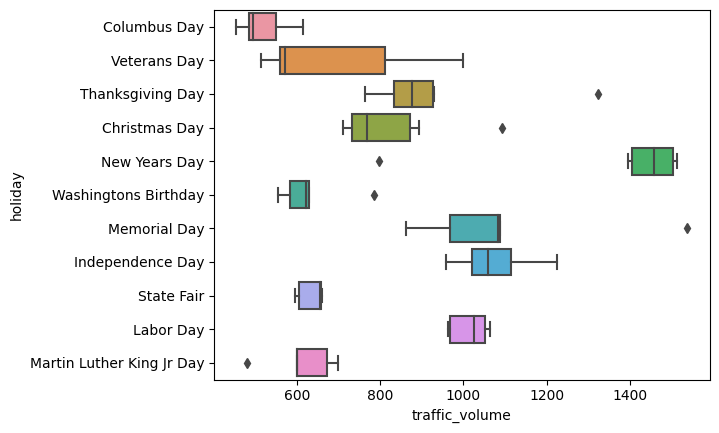

In [422]:
# Compare holiday boxplots
sns.boxplot(x=traffic_df_holidays['traffic_volume'],y=traffic_df_holidays['holiday'])

There appears to be a lot of traffic on new years day, and less traffic on some smaller holidays such as washingtons birthday and columbus day

In [423]:
# Unnecessary feature
traffic_df.drop('is_holiday', axis=1, inplace=True)

### How has traffic volume changed over the years?

Create a line graph of traffic from 2012-2018

<Axes: xlabel='year', ylabel='traffic_volume'>

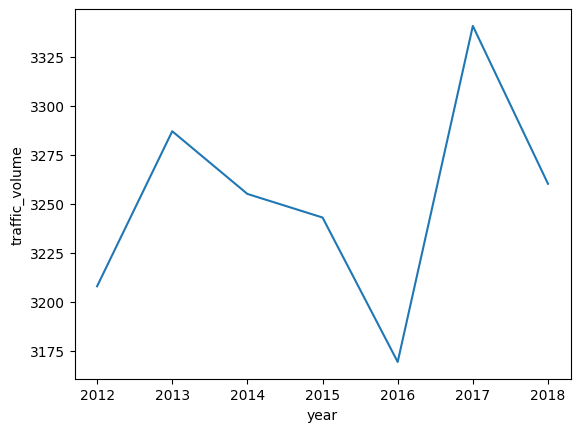

In [424]:
# Grouping dataframe by year, and aggregating year mean traffic_volume
grouped_year_traffic_df=traffic_df.groupby('year').aggregate({'traffic_volume': 'mean'})
sns.lineplot(x=grouped_year_traffic_df.index, y=grouped_year_traffic_df.traffic_volume, data=grouped_year_traffic_df)

There appears to be a slight upward trend in traffic over the years, but nothing very significant

### Which days of the week appear to have more traffic?

Weekday vs traffic_volume boxplot

In [425]:
# Create string weekday feature from numerical
def num_to_weekday(weekday_num):
  if weekday_num==0:
    return 'Monday'
  if weekday_num==1:
    return 'Tuesday'
  if weekday_num==2:
    return 'Wednesday'
  if weekday_num==3:
    return 'Thursday'
  if weekday_num==4:
    return 'Friday'
  if weekday_num==5:
    return 'Saturday'
  if weekday_num==6:
    return 'Sunday'

In [426]:
# Call function
traffic_df['string_weekday']=traffic_df['weekday'].apply(num_to_weekday)

<Axes: xlabel='traffic_volume', ylabel='string_weekday'>

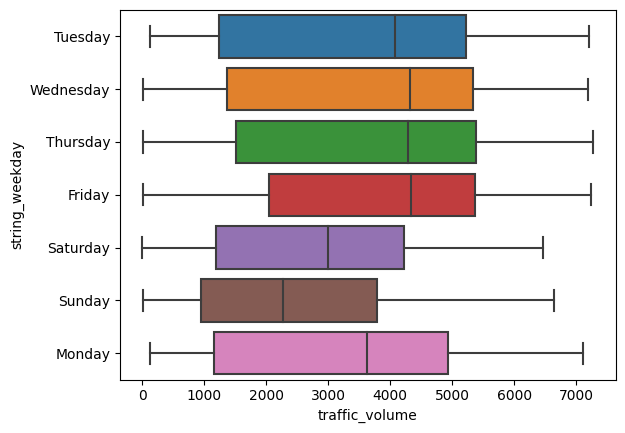

In [427]:
# Compare weekday boxplots
sns.boxplot(x=traffic_df['traffic_volume'],y=traffic_df['string_weekday'])

It appears that days later in the week have more traffic, yet weekends have less traffic than weekdays.

In [428]:
# Unnecessary feature
traffic_df.drop('string_weekday', axis=1, inplace=True)

In [429]:
traffic_df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume',
       'weather_description_binary_0', 'weather_description_binary_1',
       'weather_description_binary_2', 'hour', 'day', 'month', 'year',
       'weekday', 'is_weekend', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day',
       'sin_month', 'cos_month', 'sin_weekday', 'cos_weekday'],
      dtype='object')

# Data Transformations Analysis/Treatment for Continuous Variables

### traffic_volume

In [430]:
# Stats about each numeric feature
print(traffic_df['traffic_volume'].describe())

count    48191.000000
mean      3260.203150
std       1986.737523
min          0.000000
25%       1194.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64


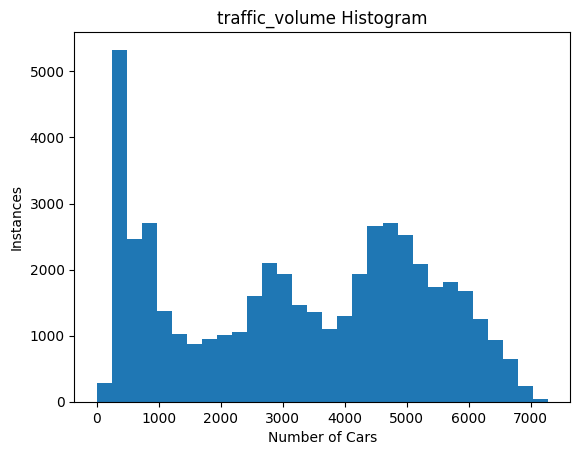

<Figure size 1000x600 with 0 Axes>

In [431]:
# Histogram
plt.hist(traffic_df['traffic_volume'], bins=30)

# Labels
plt.xlabel('Number of Cars')
plt.ylabel('Instances')
plt.title('traffic_volume Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [432]:
# Testing skew
print(pd.DataFrame(traffic_df['traffic_volume']).skew(axis=0, numeric_only='True'))

traffic_volume   -0.089602
dtype: float64


Data has no significant skew

### temp

In [433]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    48191.000000
mean       281.263322
std         12.709405
min        243.390000
25%        272.180000
50%        282.460000
75%        291.808000
max        310.070000
Name: temp, dtype: float64


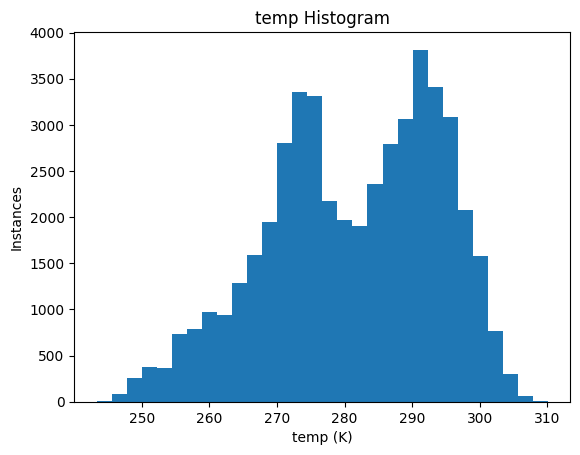

<Figure size 1000x600 with 0 Axes>

In [434]:
# Histogram
plt.hist(traffic_df['temp'], bins=30)

# Labels
plt.xlabel('temp (K)')
plt.ylabel('Instances')
plt.title('temp Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

There appears to be left-skew in the histogram, I applied square, cube, ^4, ^5, and exp transformations. ^5 transformation performed best.

In [435]:
# ^5 Transformation
traffic_df['temp']=np.power(traffic_df['temp'], 5)

In [436]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    4.819100e+04
mean     1.795648e+12
std      3.901854e+11
min      8.541097e+11
25%      1.493761e+12
50%      1.797980e+12
75%      2.115855e+12
max      2.866149e+12
Name: temp, dtype: float64


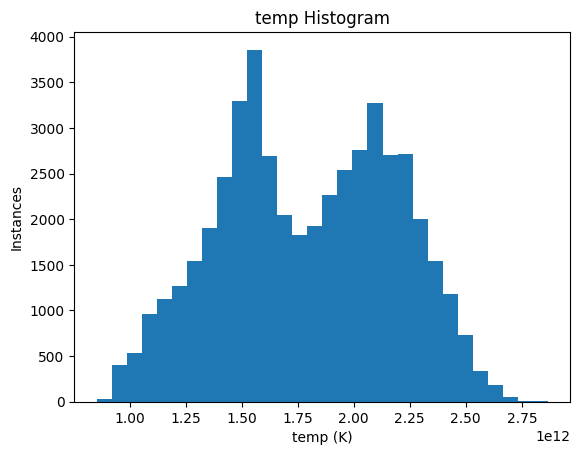

<Figure size 1000x600 with 0 Axes>

In [437]:
# Histogram
plt.hist(traffic_df['temp'], bins=30)

# Labels
plt.xlabel('temp (K)')
plt.ylabel('Instances')
plt.title('temp Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [438]:
# Testing skew
print(traffic_df['temp'].skew(axis=0, numeric_only='True'))

-0.051956520575233714


### clouds_all

In [439]:
# Stats about each numeric feature
print(traffic_df['clouds_all'].describe())

count    48191.000000
mean        49.371003
std         39.014076
min          0.000000
25%          1.000000
50%         64.000000
75%         90.000000
max        100.000000
Name: clouds_all, dtype: float64


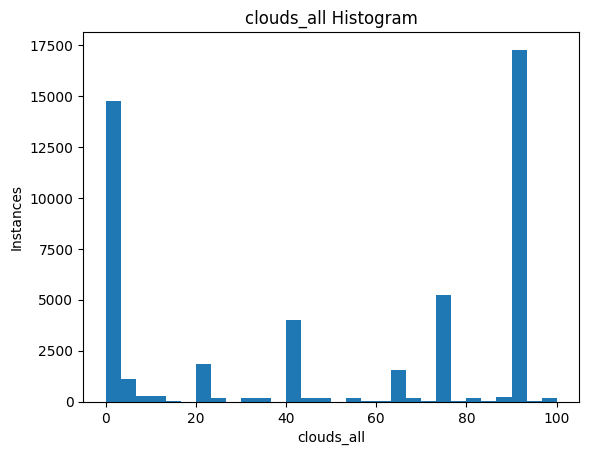

<Figure size 1000x600 with 0 Axes>

In [440]:
# Histogram
plt.hist(traffic_df['clouds_all'], bins=30)

# Labels
plt.xlabel('clouds_all')
plt.ylabel('Instances')
plt.title('clouds_all Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [441]:
# Testing skew
print(pd.DataFrame(traffic_df['clouds_all']).skew(axis=0, numeric_only='True'))

clouds_all   -0.197604
dtype: float64


Moderate skew

In [442]:
# Square Transformation
traffic_df['clouds_all']=np.power(traffic_df['clouds_all'], 2)

In [443]:
# Stats about each numeric feature
print(traffic_df['clouds_all'].describe())

count    48191.000000
mean      3959.562491
std       3622.271556
min          0.000000
25%          1.000000
50%       4096.000000
75%       8100.000000
max      10000.000000
Name: clouds_all, dtype: float64


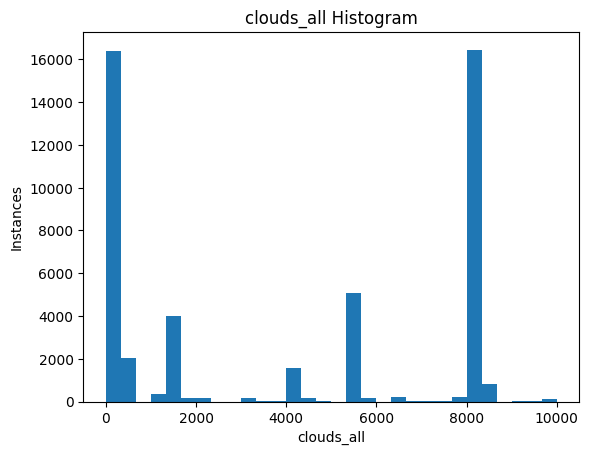

<Figure size 1000x600 with 0 Axes>

In [444]:
# Histogram
plt.hist(traffic_df['clouds_all'], bins=30)

# Labels
plt.xlabel('clouds_all')
plt.ylabel('Instances')
plt.title('clouds_all Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [445]:
# Testing skew
print(pd.DataFrame(traffic_df['clouds_all']).skew(axis=0, numeric_only='True'))

clouds_all    0.066218
dtype: float64


Improves, no significant skew

### rain_1h

I figured that I will handle rain_1h and snow_1h in the same manner. They are both continuous, zero-inflated, right-skewed features with true zeros. This rules out tobit regression and transformations.

I decided to binarize by data into rain vs. no rain and snow vs. no snow becayse for both features, there was a relative consistency amongst traffic_volumed for varying positive rain/snow values. What matters most is whether there is snow/rain.

I could have performed a two-part model or hurdle model, but I am still learning how to do that.

In [446]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48191.000000
mean         0.128270
std          0.949912
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         31.750000
Name: rain_1h, dtype: float64


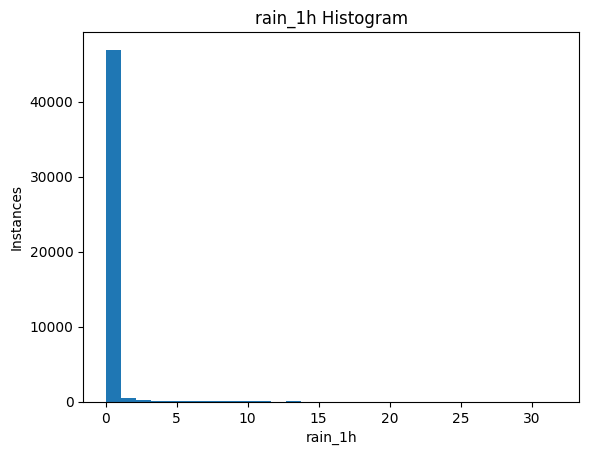

<Figure size 1000x600 with 0 Axes>

In [447]:
# Histogram
plt.hist(traffic_df['rain_1h'], bins=30)

# Labels
plt.xlabel('rain_1h')
plt.ylabel('Instances')
plt.title('rain_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [448]:
# Testing skew
print(pd.DataFrame(traffic_df['rain_1h']).skew(axis=0, numeric_only='True'))

rain_1h    15.096753
dtype: float64


Significant right skew due to zero-inflation

In [449]:
# Tranforming rain_1h into binary feature
traffic_df['rain_1h']=traffic_df['rain_1h'].apply(lambda x: 1 if x>0 else x)

In [450]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48191.000000
mean         0.071881
std          0.258293
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: rain_1h, dtype: float64


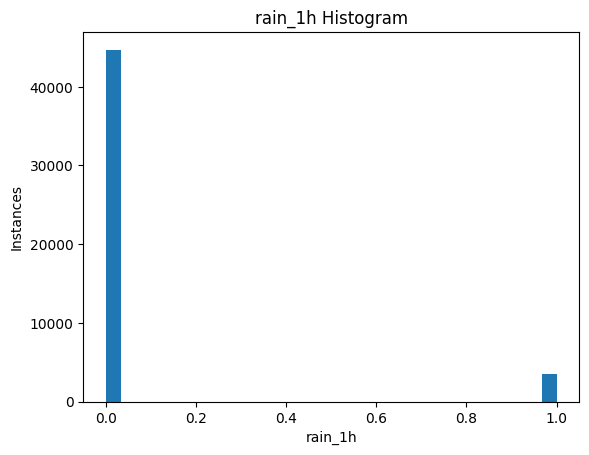

<Figure size 1000x600 with 0 Axes>

In [451]:
# Histogram
plt.hist(traffic_df['rain_1h'], bins=30)

# Labels
plt.xlabel('rain_1h')
plt.ylabel('Instances')
plt.title('rain_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [452]:
print((traffic_df['rain_1h']).value_counts())

0.0    44727
1.0     3464
Name: rain_1h, dtype: int64


No need for sampling as there are enough instances of rain and no rain to learn from

### snow_1h

In [453]:
# Stats about each numeric feature
print(traffic_df['snow_1h'].describe())

count    48191.000000
mean         0.000222
std          0.008169
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.510000
Name: snow_1h, dtype: float64


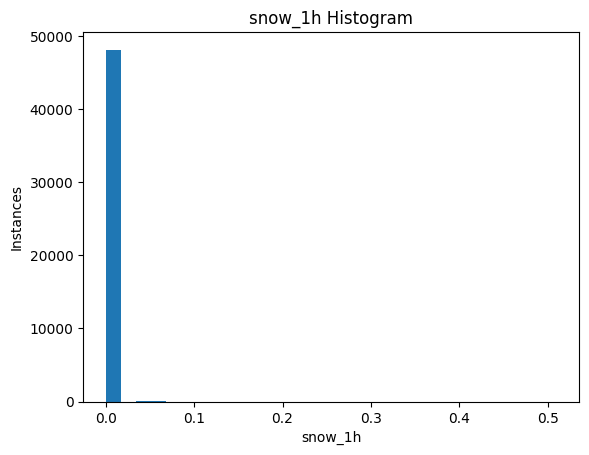

<Figure size 1000x600 with 0 Axes>

In [454]:
# Histogram
plt.hist(traffic_df['snow_1h'], bins=30)

# Labels
plt.xlabel('snow_1h')
plt.ylabel('Instances')
plt.title('snow_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [455]:
# Testing skew
print(pd.DataFrame(traffic_df['snow_1h']).skew(axis=0, numeric_only='True'))

snow_1h    48.360955
dtype: float64


Significant right skew due to zero-inflation

In [456]:
# Tranforming snow_1h into binary feature
traffic_df['snow_1h']=traffic_df['snow_1h'].apply(lambda x: 1 if x>0 else x)

In [457]:
# Stats about each numeric feature
print(traffic_df['snow_1h'].describe())

count    48191.000000
mean         0.001307
std          0.036133
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: snow_1h, dtype: float64


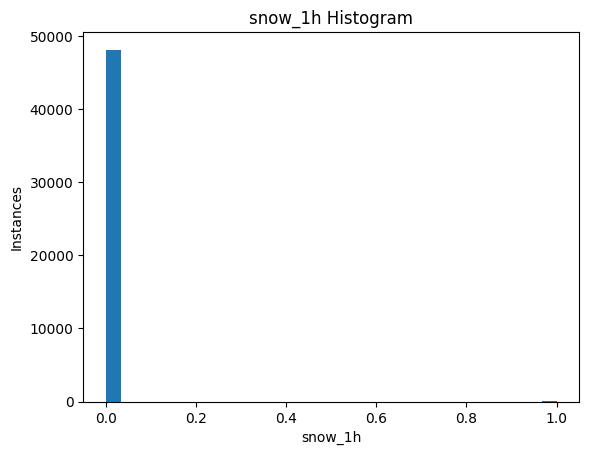

<Figure size 1000x600 with 0 Axes>

In [458]:
# Histogram
plt.hist(traffic_df['snow_1h'], bins=30)

# Labels
plt.xlabel('snow_1h')
plt.ylabel('Instances')
plt.title('snow_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [459]:
# Testing skew
print(pd.DataFrame(traffic_df['snow_1h']).skew(axis=0, numeric_only='True'))

snow_1h    27.60408
dtype: float64


In [460]:
print((traffic_df['snow_1h']).value_counts())

0.0    48128
1.0       63
Name: snow_1h, dtype: int64


63 is not great, but it is enough to learn from

#### Normalize Features

To make them conform to the same scale and improve the performance of certain models

No need to recheck desired aspects of features as they are all preserved when the features are normalized

In [461]:
myColumns=['traffic_volume', 'temp', 'clouds_all', 'rain_1h', 'snow_1h', 'hour', 'sin_hour', 'cos_hour', 'day', 'cos_day', 'sin_day', 'cos_month', 'sin_month', 'month', 'year', 'weekday', 'sin_weekday', 'cos_weekday']
for column in myColumns:
  # Normalizing
  traffic_df[column]=(traffic_df[column]-traffic_df[column].min())/(traffic_df[column].max()-traffic_df[column].min())

# Imbalanced Data Analysis/Treatment

In [462]:
traffic_df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume',
       'weather_description_binary_0', 'weather_description_binary_1',
       'weather_description_binary_2', 'hour', 'day', 'month', 'year',
       'weekday', 'is_weekend', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day',
       'sin_month', 'cos_month', 'sin_weekday', 'cos_weekday'],
      dtype='object')

# holiday
Includes all important national holidays and an important day in the state of Minnesota

In [463]:
traffic_df['holiday'].value_counts()

None                         48130
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

In [464]:
print(traffic_df.groupby('holiday').aggregate({'traffic_volume':np.mean}))

                           traffic_volume
holiday                                  
Christmas Day                    0.113668
Columbus Day                     0.071346
Independence Day                 0.147802
Labor Day                        0.139168
Martin Luther King Jr Day        0.084158
Memorial Day                     0.152143
New Years Day                    0.186264
None                             0.448247
State Fair                       0.087198
Thanksgiving Day                 0.128228
Veterans Day                     0.094973
Washingtons Birthday             0.087253


All holidays have an average of less traffic than days with no holidays.

Holidays appear to be inversely related to traffic volume, but there are very few instances of each holiday

I will attempt to oversample each holiday via SMOTE-NC (categorical and numerical) so the model can learn patterns from each holiday.

I will also undersample 'None' via ENN because the combination of SMOTE with ENN is shown to increase model performance increase model performance.

Imputation values in between discrete numerical data will not negatively effect overall model performance because the patters will still  be learned.

This model performed better when compared to a model using data that was not resampled, one only using SMOTE, and one with data that was randomly over/under sampling

I will split the dataset into holiday and non-holiday so that I can oversample holiday based on the non-holiday features.

I want to make sure that there are no synthetic values in the testing set to avoid overfitting and test by model's on actual values. Test_df should not be changed by SMOTE.

I will create my x_train, x_test, y_train, and y_test in this section

y is the label feature (traffic_volume) and x is the input features

In [465]:
# Define feature to sample
holiday_series=traffic_df['holiday']

In [466]:
# Define set of features not being samples
non_holiday_df=traffic_df.drop('holiday', axis=1)

In [467]:
# Split dataset into training and testing so SMOTEENN can be performed on the training set
non_holiday_train, non_holiday_test, holiday_train, holiday_test = train_test_split(non_holiday_df, holiday_series, test_size=0.3, random_state=0)

In [468]:
# Create ML model testing sets
y_test=non_holiday_test['traffic_volume']

x_test=non_holiday_test.drop('traffic_volume', axis=1)
x_test['holiday']=holiday_test

test=x_test.assign(traffic_volume=y_test)

In [469]:
x_test.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_description_binary_0', 'weather_description_binary_1',
       'weather_description_binary_2', 'hour', 'day', 'month', 'year',
       'weekday', 'is_weekend', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day',
       'sin_month', 'cos_month', 'sin_weekday', 'cos_weekday', 'holiday'],
      dtype='object')

In [470]:
# sampling the data via SMOTE-NC
# resample=SMOTENC(categorical_features=[6],sampling_strategy={'None':48130,'Labor Day':1000,'Thanksgiving Day':1000,'Christmas Day':1000,'New Years Day':1000,'Martin Luther King Jr Day':1000,'Columbus Day':1000,'Veterans Day':1000,'Washingtons Birthday':1000,'Memorial Day':1000,'Independence Day':1000,'State Fair':1000})

# k_neighbors = highest amount possible
# n_neighbors = 7 due to better performance in most algorithms
# 33687 is the number of 'None' rows/examples in the training set
# test different numbers of neighbors for each resampling algorithm
# resample = SMOTEENN(enn=EditedNearestNeighbours(n_neighbors=7),smote=SMOTE(k_neighbors=2,sampling_strategy={'None':33687,'Labor Day':1000,'Thanksgiving Day':1000,'Christmas Day':1000,'New Years Day':1000,'Martin Luther King Jr Day':1000,'Columbus Day':1000,'Veterans Day':1000,'Washingtons Birthday':1000,'Memorial Day':1000,'Independence Day':1000,'State Fair':1000}))

resample = ADASYN(sampling_strategy={'None':33687,'Labor Day':1000,'Thanksgiving Day':1000,'Christmas Day':1000,'New Years Day':1000,'Martin Luther King Jr Day':1000,'Columbus Day':1000,'Veterans Day':1000,'Washingtons Birthday':1000,'Memorial Day':1000,'Independence Day':1000,'State Fair':1000}, n_neighbors=2)

# Distribution before resampling
print(holiday_train.value_counts())

# Under- and over-sample data
non_holiday_train,holiday_train=resample.fit_resample(non_holiday_train,holiday_train)

# Distribution after resampling
print(holiday_train.value_counts())

None                         33687
Christmas Day                    6
New Years Day                    5
Veterans Day                     5
Martin Luther King Jr Day        5
Memorial Day                     5
Labor Day                        4
Independence Day                 4
State Fair                       3
Washingtons Birthday             3
Thanksgiving Day                 3
Columbus Day                     3
Name: holiday, dtype: int64
None                         33687
Christmas Day                 1002
New Years Day                 1000
Washingtons Birthday          1000
Veterans Day                  1000
Labor Day                     1000
Martin Luther King Jr Day     1000
Memorial Day                  1000
Independence Day              1000
State Fair                     999
Thanksgiving Day               999
Columbus Day                   999
Name: holiday, dtype: int64


In [471]:
y_train=non_holiday_train['traffic_volume']

x_train=non_holiday_train.drop('traffic_volume', axis=1)
x_train['holiday']=holiday_train

train=x_train.assign(traffic_volume=y_train)

#### Binary Encode holiday

In [472]:
# Create binary number for weather column
train['holiday_binary']=train['holiday'].apply(lambda x: int(format(0,'b')) if x=='None' else int(format(1,'b')) if x=='Labor Day' else int(format(2,'b')) if x=='Christmas Day' else int(format(3,'b')) if x=='Columbus Day' else int(format(4,'b')) if x=='Independence Day' else int(format(5,'b')) if x=='Martin Luther King Jr Day' else int(format(6,'b')) if x=='Memorial Day' else int(format(7,'b')) if x=='New Years Day' else int(format(8,'b')) if x=='State Fair' else int(format(9,'b')) if x=='Thanksgiving Day' else int(format(10,'b')) if x=='Veterans Day' else int(format(11,'b')))
test['holiday_binary']=test['holiday'].apply(lambda x: int(format(0,'b')) if x=='None' else int(format(1,'b')) if x=='Labor Day' else int(format(2,'b')) if x=='Christmas Day' else int(format(3,'b')) if x=='Columbus Day' else int(format(4,'b')) if x=='Independence Day' else int(format(5,'b')) if x=='Martin Luther King Jr Day' else int(format(6,'b')) if x=='Memorial Day' else int(format(7,'b')) if x=='New Years Day' else int(format(8,'b')) if x=='State Fair' else int(format(9,'b')) if x=='Thanksgiving Day' else int(format(10,'b')) if x=='Veterans Day' else int(format(11,'b')))

In [473]:
# Convert binary weather_description feature into three binary columns
train['holiday_binary_0']=train['holiday_binary'].apply(lambda x: int((x/1000)%10))
train['holiday_binary_1']=train['holiday_binary'].apply(lambda x: int((x/100)%10))
train['holiday_binary_2']=train['holiday_binary'].apply(lambda x: int((x/10)%10))
train['holiday_binary_3']=train['holiday_binary'].apply(lambda x: int(x%10))
test['holiday_binary_0']=test['holiday_binary'].apply(lambda x: int((x/1000)%10))
test['holiday_binary_1']=test['holiday_binary'].apply(lambda x: int((x/100)%10))
test['holiday_binary_2']=test['holiday_binary'].apply(lambda x: int((x/10)%10))
test['holiday_binary_3']=test['holiday_binary'].apply(lambda x: int(x%10))

In [474]:
# Remove unnecessary features
train.drop('holiday_binary', axis=1, inplace=True)
train.drop('holiday', axis=1, inplace=True)
test.drop('holiday_binary', axis=1, inplace=True)
test.drop('holiday', axis=1, inplace=True)

# Optimizing Data for Training

In [475]:
# # Tranforming rain_1h into binary feature
# train['rain_1h']=train['rain_1h'].apply(lambda x: 1 if x>0 else x)
# test['rain_1h']=test['rain_1h'].apply(lambda x: 1 if x>0 else x)

In [ ]:
# I analyzed the patterns for each column with regards to traffic_volume
# To show for each column would take a long time, so I am only plotting the linear regression plots of x on y for the first column
for (columnName, columnData) in train.iloc[:, :1].items():
  print(columnName)
  plt.figure()
  sns.regplot(x=columnData, y=train['traffic_volume'], data='train', scatter_kws={'color':'black'}, line_kws={'color': 'red'}, lowess=True)
  plt.show()

temp


# Dimensionality Reduction Analysis/Treatment + Machine Learning

Different machine learning algorithms will call for different dimensionality reduction analysis/treatment. So, I will combine them into one section.


For each algorithm, I will make a copy of the original dataset, perform Assumption Analysis/Treatment, perform Dimensionality Reduction Analysis/Treatment, train and test a model, use GridSearchCV to optimize hyperparameters, and train and test a final model.

I will implement and evaluate each model using sci-kit learn (sklearn).

I will save the best performing final model as a .sav file with joblib.

## Algorithms

* Linear Regression (Ordinary, Ridge, Lasso, and ElasticNet)
* Polynomial Regression
* Support Vector Regression (SVR)
* Decision Tree Regression

## Linear Regression

The assumptions for the four types of linear regression are essentially the same, so I will use the same dataframe for all of them

In [ ]:
lr_train=train.copy()
lr_test=test.copy()

In [ ]:
# Define Metrics
def calcMetrics(y_test, y_pred):
  print("MSE: ", mean_squared_error(y_test, y_pred))
  print("r2 Score: ", r2_score(y_test, y_pred))

### Assumptions


#### Linearity: The relationship between the dependent variable and independent variables is linear
Test by running linear regression with traffic_volume and each variable. Then analyzing a residual values vs. predicted values plot.

Patterns in the plot constitute non-linearity

In [ ]:
# This function will regress y on x and then draw a scatterplot of the residuals.
# Fit a lowess smoother to the residual plot, which can help in determining if there is structure to the residuals
# I only show the first column to shorten run time
for (columnName, columnData) in train.iloc[:, :1].items():
  print(columnName)
  plt.figure()
  sns.residplot(x=columnData, y=train['traffic_volume'], data='train', scatter_kws={'color':'black'}, line_kws={'color': 'red'}, lowess=True)
  plt.show()

The linear regression model will simply add or subtract a number for binary features depending on whether the input binary feature is a 1 or a 0. All binary features can be kept.

Non-linear Features: sin_weekday, cos_hour, sin_hour, weekday, year, month, hour

For each non-linear feature, create an assortment of non-linearly transformed versions. Run a regressor of each version (and the original) on traffic_volume. Then pick the best performing version and replace the original feature in the dataset.

Then normalize each feature

#### hour

In [ ]:
lr_train['hour']=lr_train['hour'].transform(lambda x: 1/(x+.2))
lr_test['hour']=lr_test['hour'].transform(lambda x: 1/(x+.2))

####month

Original performed best

####weekday

In [ ]:
lr_train['weekday']=lr_train['weekday'].transform(lambda x: 1/(x+.02))
lr_test['weekday']=lr_test['weekday'].transform(lambda x: 1/(x+.02))

####sin_weekday

Original performed best

####sin_hour

In [ ]:
lr_train['sin_hour']=lr_train['sin_hour'].transform(lambda x: 1/(x+.15))
lr_test['sin_hour']=lr_test['sin_hour'].transform(lambda x: 1/(x+.15))

####cos_hour

In [ ]:
lr_train['cos_hour']=lr_train['cos_hour'].transform(lambda x: x**(1.8))
lr_test['cos_hour']=lr_test['cos_hour'].transform(lambda x: x**(1.8))

####year

Original performed best

All features appear to be approximately linear for most of their range. All features can be kept.

#### Homoscedasticity: The variance in the error terms is constant throughout the range of the independent variables
Patterns in the variance of the error terms constitutes heteroscedasticity

In [ ]:
lr_x_train=lr_train.drop('traffic_volume', axis=1)
lr_x_test=lr_test.drop('traffic_volume', axis=1)
lr_y_test=lr_test['traffic_volume']
lr_y_train=lr_train['traffic_volume']

In [ ]:
# Create series of scattetplots between each input feature and the label
# Only showing the first column to minimize run time
for (columnName, columnData) in lr_x_train.iloc[:,:1].items():
  plt.figure()
  # Calculate variance for each unique input_feature value
  unique_values = np.unique(columnData)
  variances = [np.var([columnData == val]) for val in unique_values]

  # Plot the variance as a function of input_feature
  plt.plot(unique_values, variances, marker='o')
  plt.xlabel(columnName)
  plt.ylabel('Variance')
  plt.show()

There appears to be no 'funnel shapes', clear correlations in variance, or extreme variances. All features are approximately homoscedastic.

Homoscedasticity is also not extremely important for making predictions. It is more important for confidence intervals and p-values.

#### Error values are normally distributed

Test skew of error terms

Criteria for Pandas Skew Function

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
If the skewness is less than -1 or greater than 1, the data are highly skewed

In [ ]:
# Test skew of error terms for a regressor of each x on y

for i in range(len(lr_x_train.columns)):
  print(lr_x_train.columns.values[i])
  lr=LinearRegression().fit(lr_x_train.iloc[:,i].values.reshape((-1,1)),lr_y_train)
  lr_pred=lr.predict(lr_x_train.iloc[:,i].values.reshape((-1,1)))
  print("Skew: ", (lr_y_train-lr_pred).skew(axis=0, numeric_only='True'), '\n')

sin_hour has already been transformed to maximize linearity. Also, a normal distribution value only matters for p-values and confidence intervals. This assumption is not very important for predictions which is the goal of this project.

The distribution of errors for all other feature is fairly symmetrical. Assumption is met.

#### No or Little Multicollinearity
Test using correlation matrix heatmap in seaborn

In [ ]:
# Make heatmap larger
plt.figure(figsize=(20,11))

# Display heatmap
heatmap = sns.heatmap(round(lr_x_train.assign(traffic_volume=lr_y_train).corr(),2), vmin=-1, vmax=1, annot=True, linewidths=1)

I used PCA to reduce multicollinearity, but model performance on test set decreased slightly.

Multicollinearity is only an issue if analyzing individual features or utilizing p-values or confidence intervals is important.

The main purpose of this model is **predicting** traffic_volume, so multicollinearity is not particularly harmful.

All assumptions are met, ready for training

### Training and testing multiple linear regression

In [ ]:
#Train model and Evaluate Results

# Train model
lr=LinearRegression().fit(lr_x_train, lr_y_train)

# Make predictions
lr_pred=lr.predict(lr_x_test)

# Evaluate results
calcMetrics(lr_y_test, lr_pred)